In [11]:
import json
path = 'datasets/example.txt'
records = [json.loads(line) for line in open(path)]

In [12]:
import pandas as pd

In [13]:
frame = pd.DataFrame(records)

In [14]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a            3440 non-null   object 
 1   c            2919 non-null   object 
 2   nk           3440 non-null   float64
 3   tz           3440 non-null   object 
 4   gr           2919 non-null   object 
 5   g            3440 non-null   object 
 6   h            3440 non-null   object 
 7   l            3440 non-null   object 
 8   al           3094 non-null   object 
 9   hh           3440 non-null   object 
 10  r            3440 non-null   object 
 11  u            3440 non-null   object 
 12  t            3440 non-null   float64
 13  hc           3440 non-null   float64
 14  cy           2919 non-null   object 
 15  ll           2919 non-null   object 
 16  _heartbeat_  120 non-null    float64
 17  kw           93 non-null     object 
dtypes: float64(4), object(14)
memory usage: 500.8+ K

In [15]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

We can then use the value_counts method for Series:

In [16]:
tz_counts = frame['tz'].value_counts()

In [17]:
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

In [18]:
clean_tz =frame['tz'].fillna('Missing')

In [19]:
clean_tz[clean_tz == ''] = 'Unknown'

In [20]:
tz_counts = clean_tz.value_counts()

In [21]:
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

In [22]:
import seaborn as sns

In [23]:
subset = tz_counts[:10]

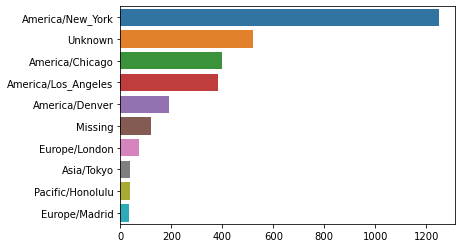

In [24]:
sns.barplot(y=subset.index, x=subset.values)

The a field contains information about the browser, device, or application used to perform the URL shortening:

In [25]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [26]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [27]:
frame['a'][51][:50]

'Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; LG-P9'

Parsing all of the interesting information in these “agent” strings may seem like a daunting task. One possible strategy is to split off the first token in the string (corresponding roughly to the browser capability) and make another summary of the user behavior:

In [28]:
results = pd.Series([x.split()[0] for x in frame.a.dropna()])

In [29]:
results[:10]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
5               Mozilla/5.0
6               Mozilla/5.0
7               Mozilla/5.0
8                Opera/9.80
9               Mozilla/5.0
dtype: object

In [30]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

Now, suppose you wanted to decompose the top time zones into Windows and non- Windows users. As a simplification, let’s say that a user is on Windows if the string 'Windows' is in the agent string. Since some of the agents are missing, we’ll exclude these from the data:

In [36]:
cframe = frame[frame.a.notnull()]

In [37]:
cframe['os'] = np.where(cframe['a'].str.contains('Windows'),'Windows', 'Not Windows')

<ipython-input-37-f23057aa7e1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cframe['os'] = np.where(cframe['a'].str.contains('Windows'),'Windows', 'Not Windows')


In [38]:
cframe['os'][:5]

0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

Then, you can group the data by its time zone column and this new list of operating
systems:

In [39]:
by_tz_os = cframe.groupby(['tz', 'os'])

The group counts, analogous to the value_counts function, can be computed with
size. This result is then reshaped into a table with unstack:

In [40]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [41]:
agg_counts[:10]

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


Finally, let’s select the top overall time zones. To do so, I construct an indirect index
array from the row counts in agg_counts:

In [42]:
indexer = agg_counts.sum(1).argsort()

In [43]:
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

I use take to select the rows in that order, then slice off the last 10 rows (largest
values):

In [44]:
count_subset = agg_counts.take(indexer[-10:])

In [45]:
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


pandas has a convenience method called nlargest that does the same thing:

In [47]:
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

Then, as shown in the preceding code block, this can be plotted in a bar plot; I’ll
make it a stacked bar plot by passing an additional argument to seaborn’s barplot
function

In [48]:
count_subset = count_subset.stack()

In [49]:
count_subset.name = 'total'

In [50]:
count_subset = count_subset.reset_index()

In [51]:
count_subset[:10]

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0
5,Pacific/Honolulu,Windows,36.0
6,Asia/Tokyo,Not Windows,2.0
7,Asia/Tokyo,Windows,35.0
8,Europe/London,Not Windows,43.0
9,Europe/London,Windows,31.0


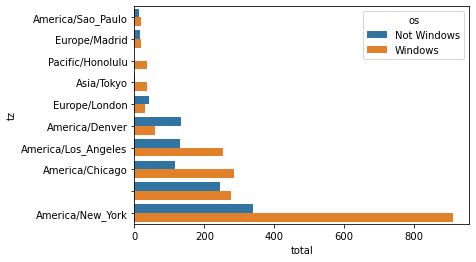

In [53]:
sns.barplot(x='total', y='tz', hue='os', data=count_subset)

In [54]:
def norm_total(group):
    group['normed_total'] = group.total / group.total.sum()
    return group

In [55]:
results = count_subset.groupby('tz').apply(norm_total)

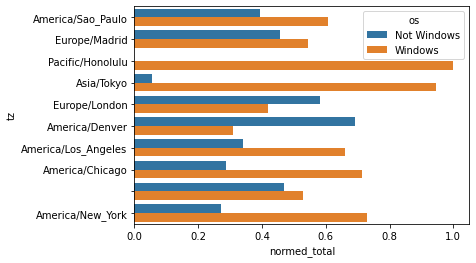

In [56]:
sns.barplot(x='normed_total', y='tz', hue='os', data=results)

We could have computed the normalized sum more efficiently by using the trans
form method with groupby: